In [3]:
import logging
import json
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import requests, zipfile
from IPython.display import Image
from IPython.display import display
import sys
import os
import math
import numpy as np
import seaborn as sns
import random
import pickle
random.seed(42)

# Import TensorFlow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [11]:
print(os.getcwd())
print(dir())

/home/studio-lab-user/abalone-regression/deep_learning/Keras
['ConfusionMatrixDisplay', 'GridSearchCV', 'Image', 'In', 'Out', 'SVC', 'StandardScaler', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'columns', 'confusion_matrix', 'display', 'exit', 'get_ipython', 'json', 'keras', 'layers', 'logging', 'math', 'np', 'os', 'pd', 'pickle', 'plot_model', 'plt', 'quit', 'random', 'requests', 'sns', 'sys', 'tf', 'train_test_split', 'zipfile']


In [13]:
columns = ['sex', 'length', 'diameter', 'height', 'whole_weight',
           'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df = pd.read_csv('../../data/abalone.csv', header=None, names=columns, index_col=False)

In [14]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [13]:
abalone_loader

In [69]:
@d2l.add_to_class(AbaloneDeep)
def preprocess(self):
    # Remove the ID and label columns
    label = 'rings'
    features = pd.concat(
        (self.raw_train.drop(columns=label),
         self.raw_val.drop(columns=label)))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding.
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [70]:
data.preprocess()
data.train.shape

(2923, 13)

In [71]:
@d2l.add_to_class(AbaloneDeep)
def get_dataloader(self, train):
    label = 'rings'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of rings
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [72]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(AbaloneDeep(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [73]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [74]:
data.train

,index,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M,sex_nan,rings
0,0.615287,0.008393,0.222882,-0.107978,0.030094,0.329481,-0.005415,-0.411852,1,0,0,0,9
1,-0.964393,-0.782662,-0.835161,-0.944757,-0.946681,-0.909465,-0.894898,-0.961410,0,1,0,0,7
2,1.456954,-0.574489,-0.583246,-0.825217,-0.841663,-0.886939,-0.762616,-0.674059,0,0,1,0,11
3,-1.277841,-2.656211,-2.548182,-2.259695,-1.603303,-1.542453,-1.597362,-1.604358,0,0,1,0,7
4,0.141798,0.549640,0.575563,0.489721,0.554168,0.660617,0.655995,0.403506,1,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,1.124434,-0.283048,-0.079416,-0.586137,-0.529666,-0.465697,-0.438753,-0.674059,1,0,0,0,9
2919,-1.345008,1.215791,1.432073,1.206960,1.145535,0.825059,1.121263,1.157802,1,0,0,0,12
2920,0.832545,-0.116511,-0.129799,-0.347058,-0.506215,-0.519760,-0.429630,-0.365157,0,0,1,0,11
2921,1.396421,0.424737,0.575563,-0.466597,0.458326,0.705670,0.345816,-0.027520,0,0,1,0,9


/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/studio-lab-user/.conda/envs/py39/lib/python3.9/site-packages/torch/nn/modules/lazy

average validation log mse = 0.060122925266623495


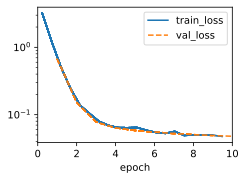

In [75]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)